In [72]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import math

# processing the terrain data

In [306]:
path="rasters/dem.asc"

In [307]:
terrain=pd.read_csv(path,header=None,skiprows=6,delimiter=" ",skipinitialspace =True).values[:,:-1]#remove the last column, which are nan

In [308]:
mask=terrain<0
terrain[mask]=0
vmin=np.min(terrain)
vmax=np.max(terrain)
terrain_rescale = (terrain - vmin) / (vmax - vmin)
mask_bin=np.zeros_like(mask,dtype=np.float32)
mask_bin[mask]=1

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

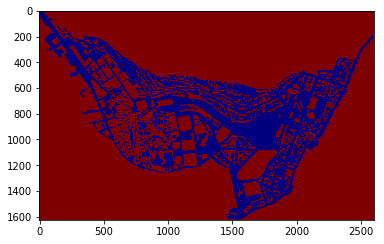

In [309]:
#mask channel
plt.imshow(mask_bin, cmap=plt.cm.jet)
mask

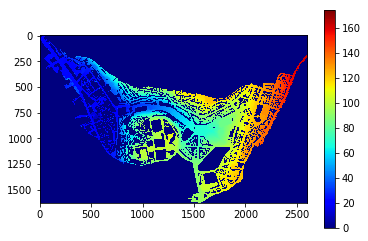

In [310]:
#terrain channel
plt.imshow(terrain, cmap=plt.cm.jet)
plt.colorbar()

In [282]:
#calculating curvature / slop / direction: if the neribhgor is missing, just replace it with the center value
def slop(array,cell_size=1):
    e = array[1,1]
    a = array[0,0] if array[0,0]>0 else e
    b = array[0,1] if array[0,1]>0 else e
    c = array[0,2] if array[0,2]>0 else e
    d = array[1,0] if array[1,0]>0 else e
    f = array[1,2] if array[1,2]>0 else e
    g = array[2,0] if array[2,0]>0 else e
    h = array[2,1] if array[2,1]>0 else e
    i = array[2,2] if array[2,2]>0 else e
    dx= ((c + 2*f + i) - (a + 2*d + g)) / (8*cell_size)
    dy= ((g + 2*h + i) - (a + 2*b + c)) / (8*cell_size)
    return math.atan(math.sqrt(dx*dx + dy*dy)) # in radian

In [283]:
slop(np.zeros((3,3)))

0.0

In [77]:
def aspect(array,cell_size=1):
    e = array[1,1]
    a = array[0,0] if array[0,0]>0 else e
    b = array[0,1] if array[0,1]>0 else e
    c = array[0,2] if array[0,2]>0 else e
    d = array[1,0] if array[1,0]>0 else e
    f = array[1,2] if array[1,2]>0 else e
    g = array[2,0] if array[2,0]>0 else e
    h = array[2,1] if array[2,1]>0 else e
    i = array[2,2] if array[2,2]>0 else e
    dx= ((c + 2*f + i) - (a + 2*d + g)) / (8*cell_size)
    dy= ((g + 2*h + i) - (a + 2*b + c)) / (8*cell_size)
    ang = math.atan2(dy, -dx)
    return math.cos(ang),math.sin(ang)

In [79]:
aspect(np.ones((3,3)))

(-1.0, 1.2246467991473532e-16)

In [171]:
def curvature(array,cell_size=1):
    z5 = array[1,1]
    z2 = array[0,1] if array[0,1]>0 else z5
    z4 = array[1,0] if array[1,0]>0 else z5
    z6 = array[1,2] if array[1,2]>0 else z5
    z8 = array[2,1] if array[2,1]>0 else z5
    
    d = ((z4 + z6) /2 - z5) / (cell_size*cell_size)
    e = ((z2 + z8) /2 - z5) / (cell_size*cell_size)
    
    return -2 * (d + e) #* 100 # why 100 here?

In [83]:
curvature(np.ones((3,3)))

-0.0

In [316]:
def slop_array(array, cell_size=1):
    h, w = array.shape
    array_pad=np.pad(array,1,'constant',constant_values=-1)
    slop_result = [[0 if array[i,j]<=0 else slop(array_pad[i:i+3,j:j+3],cell_size) for j in range(w)] for i in range(h)]
    return np.array(slop_result)

In [313]:
def aspect_array(array, cell_size=1):
    h, w = array.shape
    array_pad=np.pad(array,1,'constant',constant_values=-1)
    aspect_result = [[[0,0] if array[i,j]<=0 else aspect(array_pad[i:i+3,j:j+3],cell_size) for j in range(w)] for i in range(h)]
    return np.array(aspect_result)

In [314]:
def curvature_array(array, cell_size=1):
    h, w = array.shape
    array_pad=np.pad(array,1,'constant',constant_values=-1)
    curvature_result = [[0 if array[i,j]<=0 else curvature(array_pad[i:i+3,j:j+3],cell_size) for j in range(w)] for i in range(h)]
    return np.array(curvature_result)

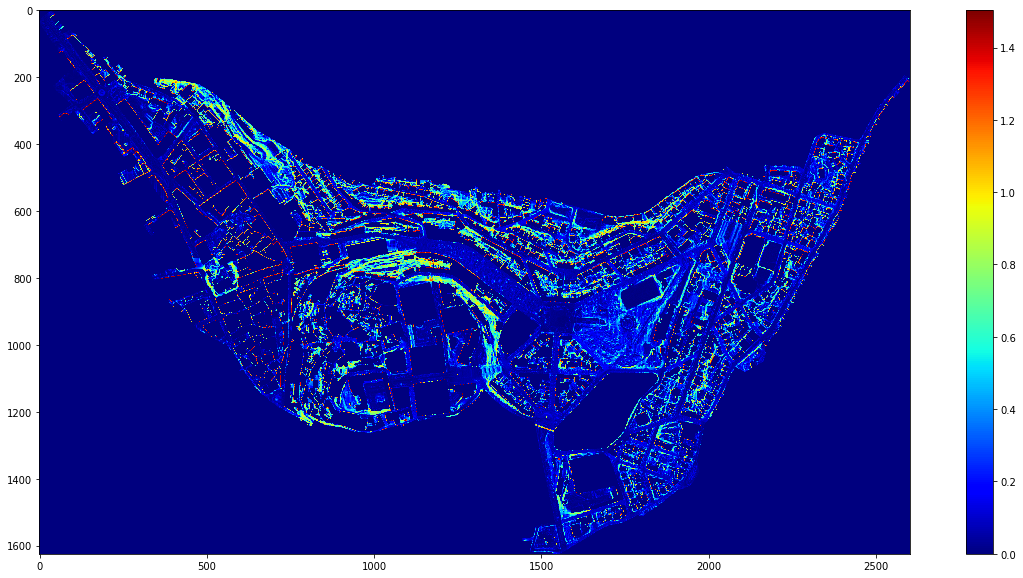

In [317]:
slop_result = slop_array(terrain)
plt.figure(figsize=(20,10))
plt.imshow(slop_result, cmap=plt.cm.jet)
plt.colorbar()
plt.savefig("slop_result.png")

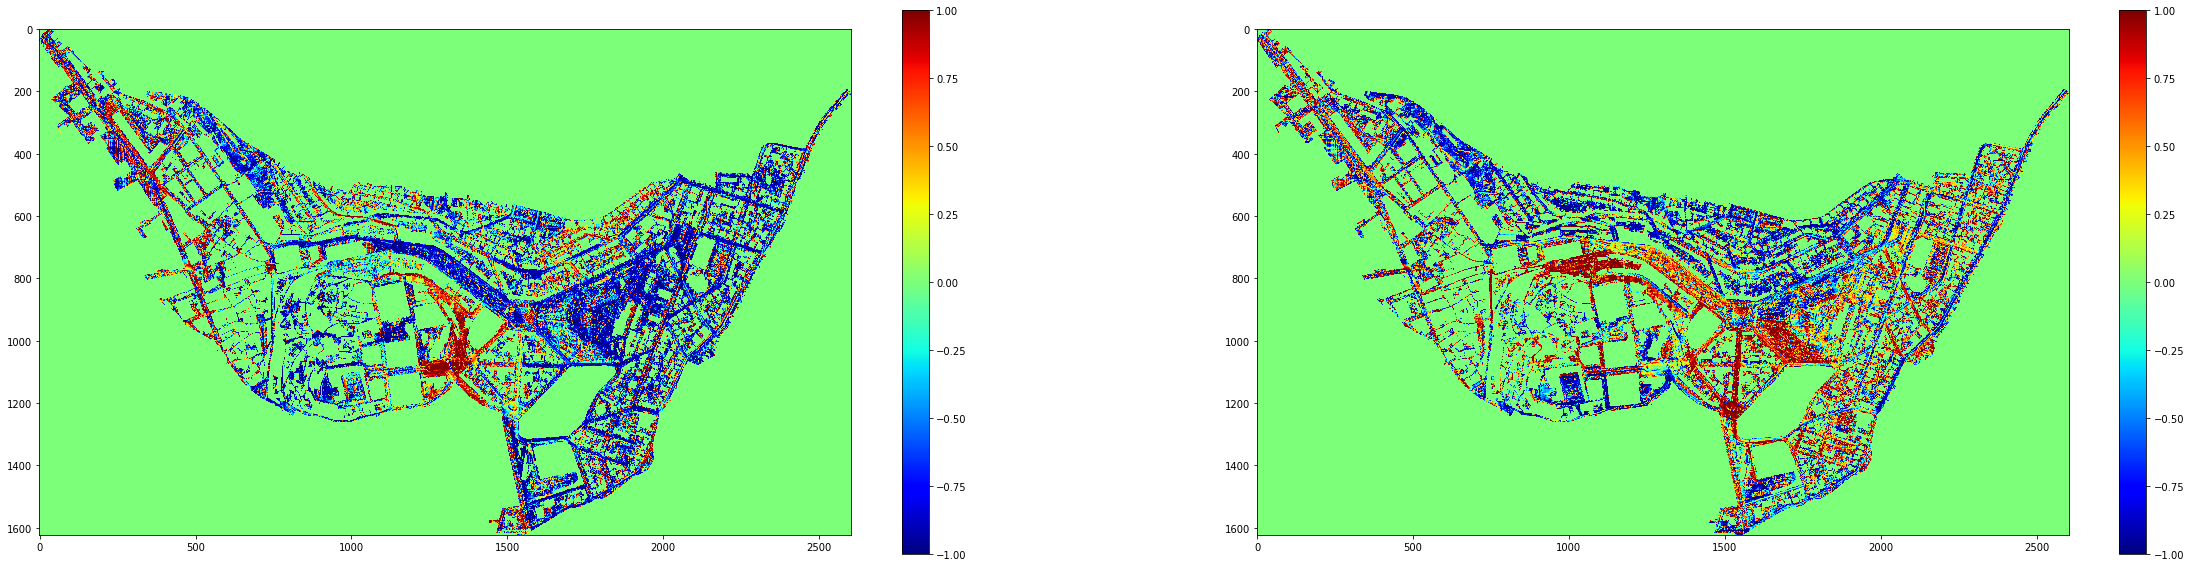

In [318]:
aspect_result = aspect_array(terrain)
plt.figure(figsize=(40,10))
plt.subplot(1,2,1)
plt.imshow(aspect_result[:,:,0], cmap=plt.cm.jet)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(aspect_result[:,:,1], cmap=plt.cm.jet)
plt.colorbar()
plt.savefig("aspect_result.png")

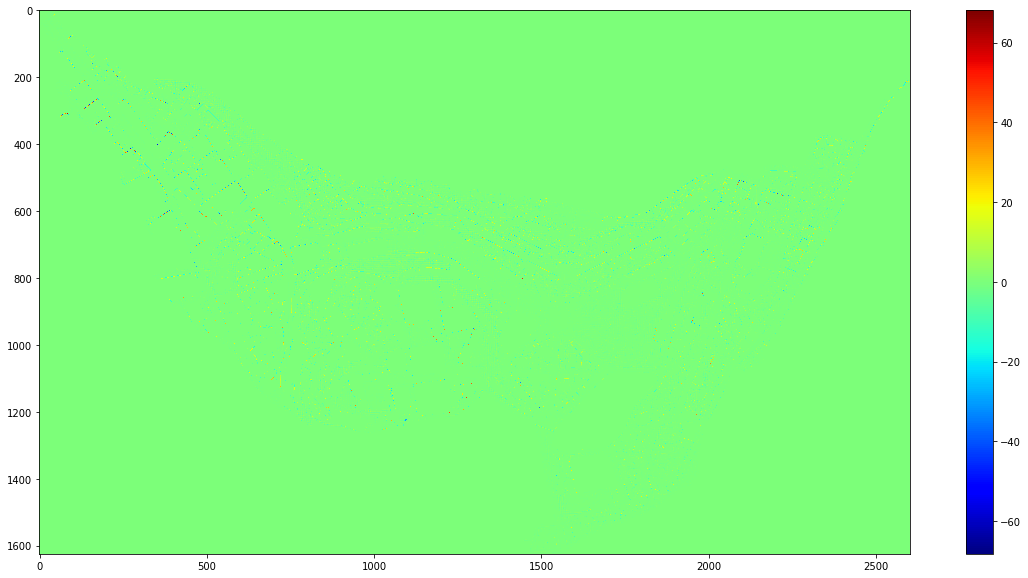

In [319]:
curvature_result = curvature_array(terrain)
plt.figure(figsize=(20,10))
plt.imshow(curvature_result, cmap=plt.cm.jet)
plt.colorbar()
plt.savefig("curvature_result.png")

In [320]:
curvature_result_rescale=curvature_result*0.1

In [326]:
all_data=np.array([terrain_rescale,mask, slop_result,aspect_result[:,:,0],aspect_result[:,:,1],curvature_result_rescale])
all_data.shape

(6, 1625, 2603)

In [328]:
np.save("terrain.npy",all_data)

# process the label data

In [332]:
path=["rasters/tr2-1.asc","rasters/tr5-1.asc","rasters/tr10-1.asc",
      "rasters/tr20-1.asc","rasters/tr50-1.asc","rasters/tr100-1.asc",
      "rasters/tr2-2.asc","rasters/tr5-2.asc","rasters/tr10-2.asc",
      "rasters/tr20-2.asc","rasters/tr50-2.asc","rasters/tr100-2.asc",
      "rasters/tr2-3.asc","rasters/tr5-3.asc","rasters/tr10-3.asc",
      "rasters/tr50-3.asc","rasters/tr100-3.asc"
     ]

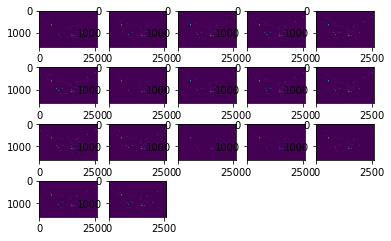

In [349]:
water_level=[pd.read_csv(p,header=None,skiprows=6,delimiter=" ",skipinitialspace =True).values[:,:-1] for p in path]#remove the last column, which are nan
for w in water_level:
    w[mask]=0

for i in range(len(water_level)):
    plt.subplot(4,5,i+1)
    plt.imshow(water_level[i])

In [350]:
water_level=np.array(water_level)
np.save("water_level.npy",water_level)

# validate the data

In [358]:
data=np.load("water_level.npy")

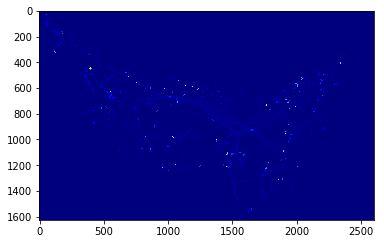

In [360]:
plt.imshow(data[1], cmap=plt.cm.jet)

# some tests, shooting rays and so on

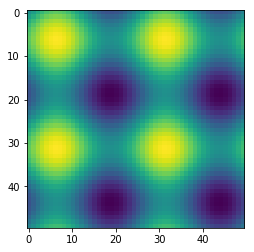

In [218]:
# give a dimension, say 5x5
h,w=50,50
indices=np.mgrid[0:h,0:w]

# a terrain made by sine functions
image=np.sin(indices[0] / h * 4 * math.pi)+np.sin(indices[1] / w * 4 * math.pi)+2
plt.imshow(image)

In [223]:
# a poi at (2,2)
poi=[15,27]
dxy=np.array([indices[0]-poi[0],indices[1]-poi[1]])

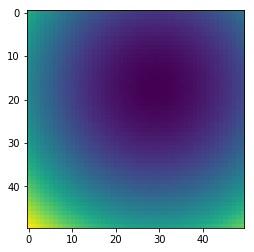

In [226]:
#dist from all points to poi
dist2 = dxy[0]*dxy[0] + dxy[1]*dxy[1]
plt.imshow(dist2)

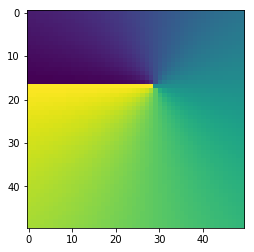

In [227]:
# the angles from all points to poi
ang=np.arctan2(dxy[0],dxy[1])
plt.imshow(ang)

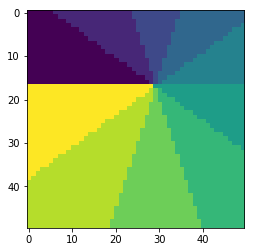

In [237]:
#convert the ang to spectrum
spectrum_num=10
spectrum = np.floor(spectrum_num * (ang+math.pi) / (2 * math.pi))
spectrum[spectrum==spectrum_num]=spectrum_num-1
plt.imshow(spectrum)

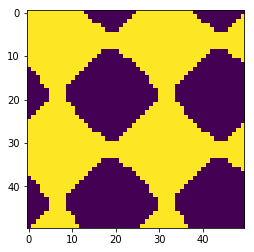

In [248]:
mask_height=image>image[poi[0],poi[1]]
plt.imshow(mask_height)

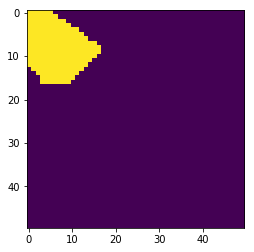

In [255]:
mask_spectrum_0= np.logical_and(spectrum==0, mask_height)
plt.imshow(mask_spectrum_0)